In [34]:
import pandas as pd
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme.expressions import Derive, Beta, Variable, log, exp
from biogeme import models
from biogeme import results as res
data_file='lpmc10.dat'
lpmc = pd.read_csv(data_file, sep='\t')
lpmc

,trip_id,household_id,person_n,trip_n,travel_mode,purpose,fueltype,faretype,bus_scale,survey_year,...,dur_pt_access,dur_pt_rail,dur_pt_bus,dur_pt_int,pt_interchanges,dur_driving,cost_transit,cost_driving_fuel,cost_driving_ccharge,driving_traffic_percent
0,20,5,1,0,4,3,1,5,0.0,1,...,0.381667,0.000000,0.062222,0.000000,0,0.117222,0.00,0.41,0.0,0.097156
1,41,9,3,0,4,3,1,5,0.0,1,...,0.146944,0.000000,0.225000,0.000000,0,0.200833,0.00,0.48,0.0,0.378976
2,69,13,2,1,4,3,1,1,1.0,1,...,0.029444,0.083333,0.735833,0.398056,3,0.716944,6.00,2.16,0.0,0.582720
3,102,20,2,0,2,3,1,1,1.0,1,...,0.339722,0.183333,0.116667,0.266667,1,0.250833,3.00,0.89,0.0,0.170543
4,105,21,0,1,4,3,1,1,1.0,1,...,0.126389,0.000000,0.150000,0.000000,0,0.125833,1.50,0.37,0.0,0.154525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,80998,17591,0,5,4,3,1,5,0.0,3,...,0.189167,0.000000,0.117778,0.000000,0,0.082500,0.00,0.22,10.5,0.239057
4996,81000,17592,0,0,3,3,6,5,0.0,3,...,0.105278,0.000000,0.220278,0.000000,0,0.213611,0.00,0.52,0.0,0.412224
4997,81015,17597,0,3,4,3,1,5,0.0,3,...,0.343056,0.000000,0.177500,0.000000,0,0.189444,0.00,0.76,0.0,0.086510
4998,81041,17604,2,4,3,1,1,2,0.0,3,...,0.344444,0.316667,0.000000,0.083333,1,0.386111,1.05,0.98,0.0,0.340288


In [35]:
lpmc['cost_driving']=lpmc['cost_driving_ccharge']+lpmc['cost_driving_fuel']
lpmc['dur_public']=lpmc['dur_pt_access']+lpmc['dur_pt_rail']+lpmc['dur_pt_bus']+lpmc['dur_pt_int']

In [36]:
database = db.Database('trips', lpmc)
lpmc.columns
for col in lpmc.columns:
    globals()[col]=Variable(col)

In [37]:
lambda_boxcox = Beta('lambda_boxcox', 1, None, None, 0)
boxcox_time_1 = models.boxcox(dur_walking, lambda_boxcox)
boxcox_time_2 = models.boxcox(dur_cycling, lambda_boxcox)
boxcox_time_3 = models.boxcox(dur_public, lambda_boxcox)
boxcox_time_4 = models.boxcox(dur_driving, lambda_boxcox)

In [38]:
asc_walk = Beta('asc_walk', 0, None, None, 1) 
asc_cycling = Beta('asc_cycling', 0, None, None, 0)
asc_public = Beta('asc_public', 0, None, None, 0)
asc_driving = Beta('asc_driving', 0, None, None, 0)

beta_time_walk = Beta('beta_time_walk', 0, None, None, 0)
beta_time_cycling = Beta('beta_time_cycling', 0, None, None, 0)
beta_time_driving = Beta('beta_time_driving', 0, None, None, 0)
beta_time_public = Beta('beta_time_public', 0, None, None, 0)

beta_cost = Beta('beta_cost', 0, None, None, 0)

# alternative attribute
beta_traffic = Beta('beta_driving_traffic_percent',0, None, None,0)
beta_interchange = Beta('beta_interchange',0, None, None,0)
# social economics characteristics
beta_drivinglicense = Beta('beta_drivinglicense',0,None,None,0)

V_walk = asc_walk + beta_time_walk * boxcox_time_1
V_cycling = asc_cycling + beta_time_cycling * boxcox_time_2
V_public = asc_public + beta_time_public * boxcox_time_3+ beta_cost * cost_transit 
V_driving = asc_driving + beta_drivinglicense*driving_license + beta_time_driving * boxcox_time_4 + beta_cost * cost_driving +beta_traffic*driving_traffic_percent

V = {1: V_walk, 2: V_cycling, 3: V_public, 4: V_driving}

logprob = models.loglogit(V, None, travel_mode)

biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'model_3_test'
results3_test = biogeme.estimate()
print(results3_test.printGeneralStatistics())

Number of estimated parameters:	11
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4071.611
Final log likelihood:	-4071.611
Likelihood ratio test for the init. model:	1.79436e-07
Rho-square for the init. model:	2.2e-11
Rho-square-bar for the init. model:	-0.0027
Akaike Information Criterion:	8165.221
Bayesian Information Criterion:	8236.91
Final gradient norm:	2.1502E-02
Nbr of threads:	4



In [39]:
results3_test.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_cycling,-1.804938,0.279523,-6.457212,1.066496e-10
asc_driving,0.814862,0.273886,2.975183,2.928139e-03
asc_public,1.974100,0.173881,11.353153,0.000000e+00
beta_cost,-0.091493,0.014584,-6.273457,3.531180e-10
beta_driving_traffic_percent,-2.601054,0.240714,-10.805560,0.000000e+00
beta_drivinglicense,1.445317,0.071811,20.126771,0.000000e+00
beta_time_cycling,-3.026531,0.276832,-10.932735,0.000000e+00
beta_time_driving,-2.650898,0.270059,-9.815996,0.000000e+00
beta_time_public,-2.224313,0.191609,-11.608583,0.000000e+00
beta_time_walk,-5.377131,0.298873,-17.991366,0.000000e+00


In [40]:
MU_motorized = Beta('MU_motorized', 1, 0, None, 0)
motorized = MU_motorized, [3, 4]
non_motorized = 1, [1,2]
nests = motorized, non_motorized
logprob = models.lognested(V, None, nests, travel_mode)
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'model_4_test'
results4_test = biogeme.estimate(recycle=False)

In [41]:
results4_test.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
MU_motorized,2.012965,0.262593,7.665730,1.776357e-14
asc_cycling,-0.957097,0.280030,-3.417841,6.311990e-04
asc_driving,2.099893,0.266748,7.872183,3.552714e-15
asc_public,2.779609,0.198556,13.999120,0.000000e+00
beta_cost,-0.037382,0.010141,-3.686252,2.275809e-04
beta_driving_traffic_percent,-1.402784,0.229768,-6.105231,1.026520e-09
beta_drivinglicense,0.845087,0.102553,8.240507,2.220446e-16
beta_time_cycling,-1.879607,0.240640,-7.810862,5.773160e-15
beta_time_driving,-1.414713,0.211527,-6.688086,2.261080e-11
beta_time_public,-1.207234,0.173126,-6.973161,3.099077e-12


In [42]:
modes = ["walk","cycling","public","driving"]
census = {
    'male_41_more':  1633263,
    'male_40_less':  2676249,
    'female_41_more':  1765143,
    'female_40_less':  2599058
}
total = sum(census.values())
total


8673713

In [43]:
lpmc["40_less"]=lpmc["age"]<=40
lpmc["40_less"]

0       False
1        True
2        True
3        True
4       False
        ...  
4995    False
4996    False
4997    False
4998     True
4999     True
Name: 40_less, Length: 5000, dtype: bool

In [44]:
filters = {
    'male_41_more': (lpmc['40_less'] == 0) & (lpmc['female'] == 0),
    'male_40_less': (lpmc['40_less'] == 1) & (lpmc['female'] == 0),
    'female_41_more': (lpmc['40_less'] == 0) & (lpmc['female'] == 1),
    'female_40_less': (lpmc['40_less'] == 1) & (lpmc['female'] == 1)
}
sample_segments = {
    k: v.sum() for k, v in filters.items()
}
sample_segments

{'male_41_more': 1084,
 'male_40_less': 1256,
 'female_41_more': 1204,
 'female_40_less': 1456}

In [45]:
total_sample = sum(sample_segments.values())
total_sample

5000

In [46]:
# weight associated with each segment
weights = {
    k: census[k] * total_sample / (v * total) 
    for k, v in sample_segments.items()
}
weights

{'male_41_more': 0.86854394680908,
 'male_40_less': 1.2282925990376248,
 'female_41_more': 0.8451199703160228,
 'female_40_less': 1.029009899043413}

In [47]:
for k, f in filters.items():
    lpmc.loc[f, 'Weight'] = weights[k] 
lpmc['Weight']

0       0.845120
1       1.029010
2       1.228293
3       1.228293
4       0.868544
          ...   
4995    0.845120
4996    0.845120
4997    0.868544
4998    1.228293
4999    1.029010
Name: Weight, Length: 5000, dtype: float64

In [55]:
#vot_public = Derive(V_public,'dur_public') / Derive (V_public,'cost_transit')
#vot_driving = Derive(V_driving,'dur_driving') / Derive (V_driving,'cost_driving')

vot_public_boxtime = Derive(V_public,boxcox_time_3) / Derive (V_public,'cost_transit')
vot_driving_boxtime = Derive(V_driving,boxcox_time_4) / Derive (V_driving,'cost_driving')
vot_public = Derive(boxcox_time_3,'dur_public')*vot_public_boxtime
vot_driving = Derive(boxcox_time_4,'dur_driving')*vot_driving_boxtime

In [56]:
Weight = Variable('Weight')
simulate = {
    'Weight': Weight,
    'VOT_public': vot_public,
    'VOT_driving': vot_driving,
    'cost_transit': cost_transit,
    'cost_driving': cost_driving,
}
biosim = bio.BIOGEME(database, simulate)
simulated_values = biosim.simulate(results4_test.getBetaValues())
lpmc['dur_driving']



[23:23:03] < Warning >   Parameter MU_motorized not present in the model
[23:23:03] < Warning >   Parameter asc_cycling not present in the model
[23:23:03] < Warning >   Parameter beta_time_cycling not present in the model
[23:23:03] < Warning >   Parameter beta_time_walk not present in the model


TypeError: unhashable type: 'Elem'

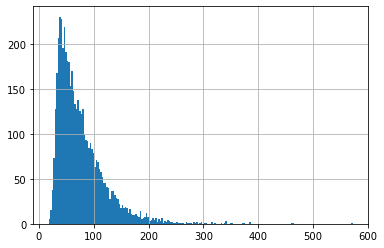

In [51]:
_ = simulated_values['VOT_public'].hist(bins=200)

In [52]:
avg_vot_pt = (
    simulated_values['VOT_public'] * 
    simulated_values['Weight']
).sum() / simulated_values['Weight'].sum()

avg_vot_pt

75.89967753662681